<a href="https://colab.research.google.com/github/SLCFLAB/DL-Forecasting/blob/main/%EA%B8%88%EC%9C%B5%EC%97%B0%EC%88%98%EC%9B%90/TimeSeriesPractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import itertools
import scipy.stats
import seaborn as sns
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots  import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings(action='ignore')

# Data

### Data Load

In [3]:
gold_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/gold.csv'
silver_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/silver.csv'
platinum_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/platinum.csv'
gold = pd.read_csv(gold_url, index_col=0)
silver = pd.read_csv(silver_url, index_col=0)
platinum = pd.read_csv(platinum_url, index_col=0)

In [4]:
price = gold.set_index(keys = 'Date')
diff = price.diff().dropna()

### Data describe

In [5]:
gold

,Date,Price
0,2017-01-03,1162.0
1,2017-01-04,1165.3
2,2017-01-05,1181.3
3,2017-01-06,1173.4
4,2017-01-09,1184.9
...,...,...
1285,2021-12-27,1808.8
1286,2021-12-28,1810.9
1287,2021-12-29,1805.8
1288,2021-12-30,1814.1


In [6]:
price

,Price
Date,
2017-01-03,1162.0
2017-01-04,1165.3
2017-01-05,1181.3
2017-01-06,1173.4
2017-01-09,1184.9
...,...
2021-12-27,1808.8
2021-12-28,1810.9
2021-12-29,1805.8


In [7]:
gold.isna().sum()

Date     0
Price    0
dtype: int64

In [8]:
gold.describe()

,Price
count,1290.000000
mean,1501.741550
std,254.202298
min,1162.000000
25%,1278.525000
50%,1411.600000
75%,1774.575000
max,2069.400000


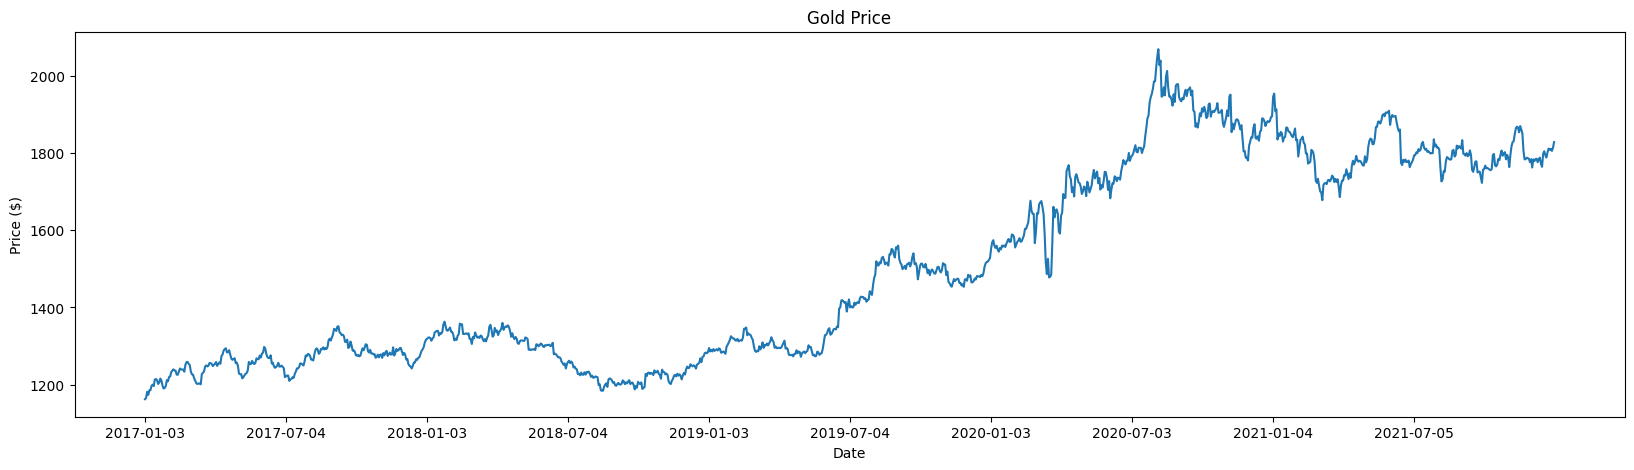

In [9]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

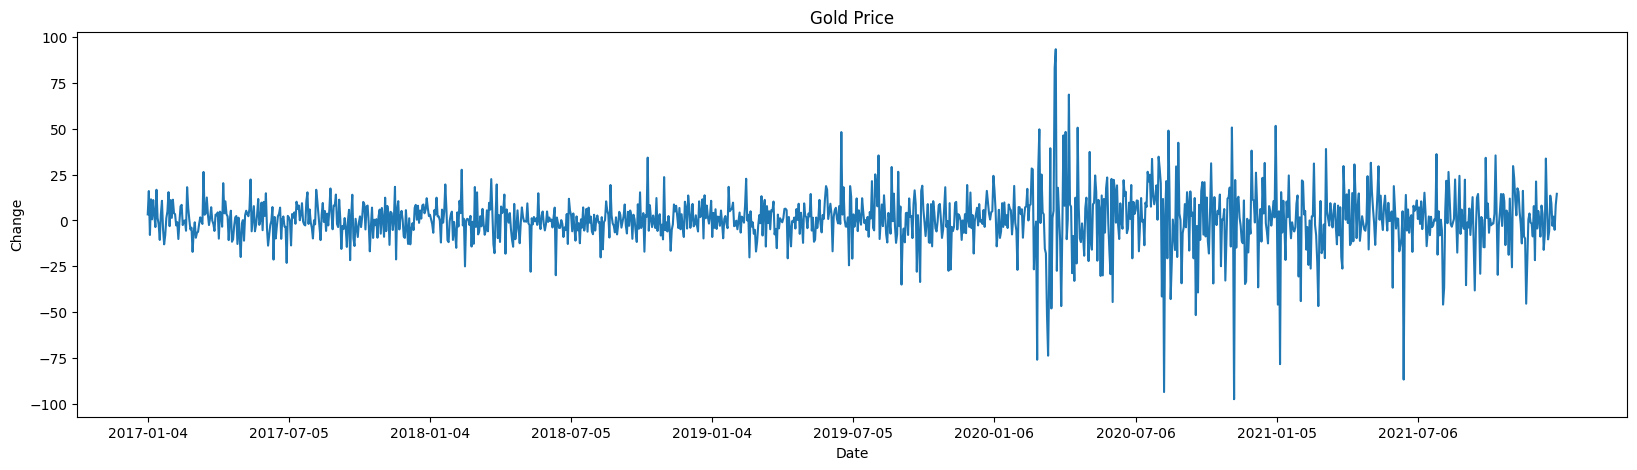

In [10]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(diff)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Change')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

# Decomposition

### Box-Cox transformation
$ y_t = \begin{cases}
{{x_t}^λ-1}\over{λ}, & \mbox{if }λ\ne 0 \\
\log{x_t}, & \mbox{if }λ= 0
\end{cases} $

In [11]:
x = gold['Price'].to_numpy()
y, lambda_optimal = stats.boxcox(x)
print(lambda_optimal)

-1.6225792875055973


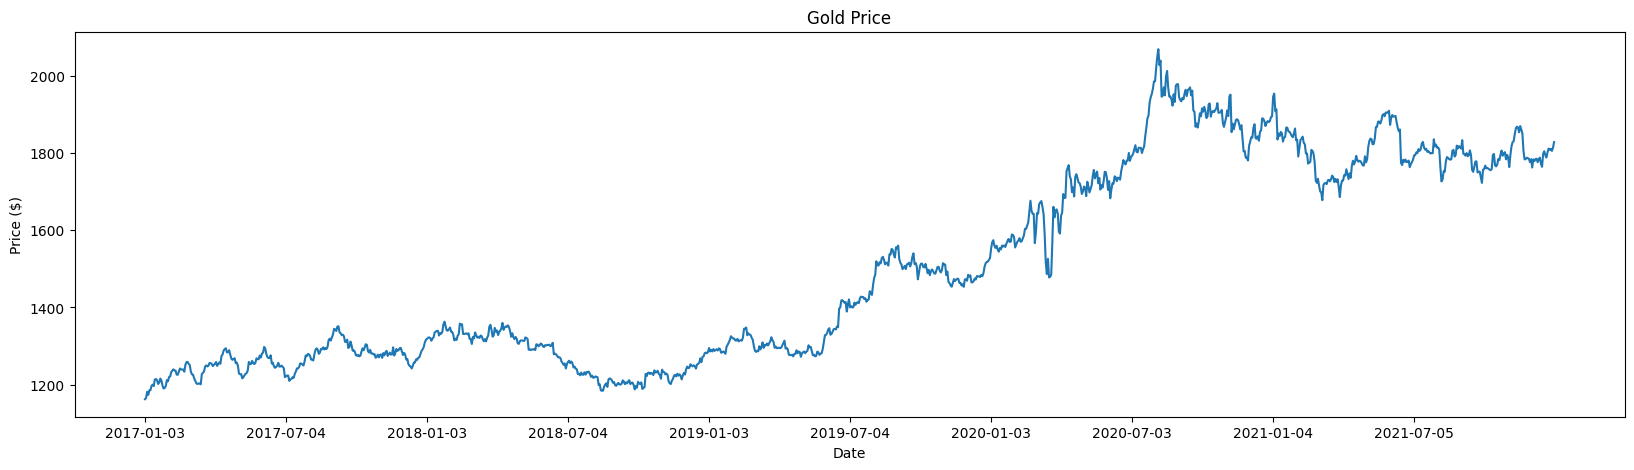

In [12]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))
plt.show()

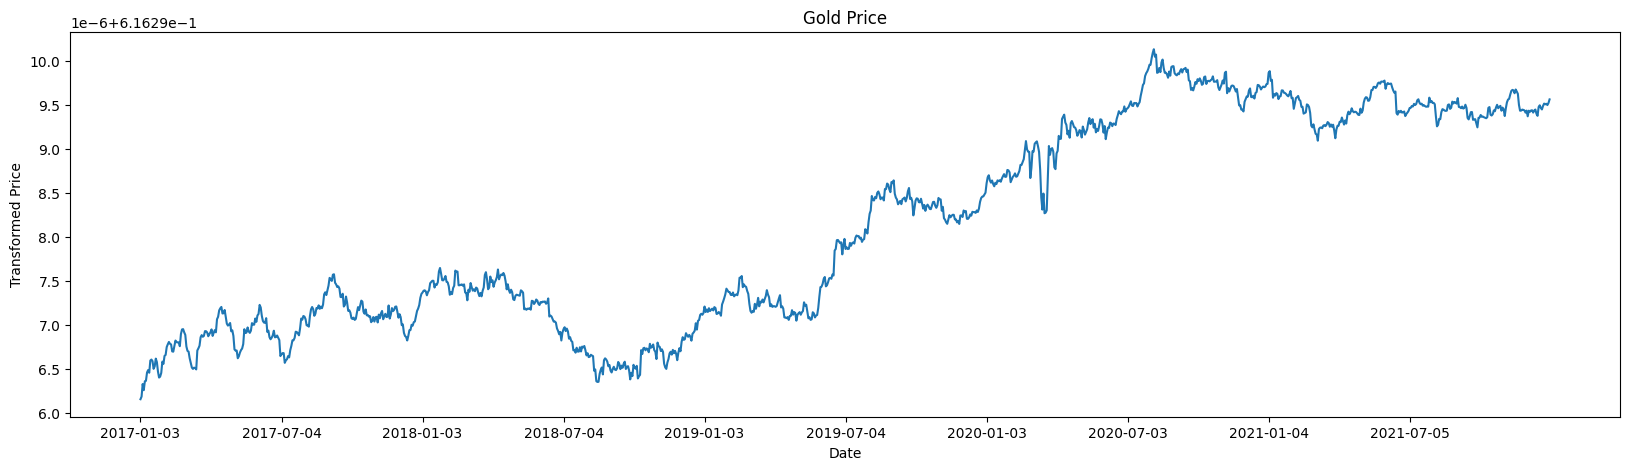

In [13]:
fig, ax = plt.subplots(figsize = (20,5))
ax.plot(gold['Date'],y)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Transformed Price')
total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))
plt.show()

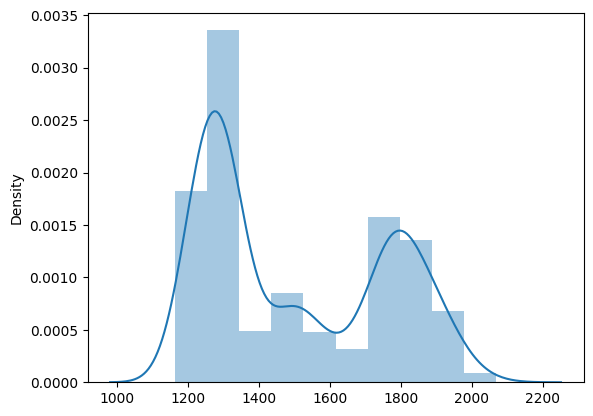

In [14]:
sns.distplot(x, hist=True)
plt.show()

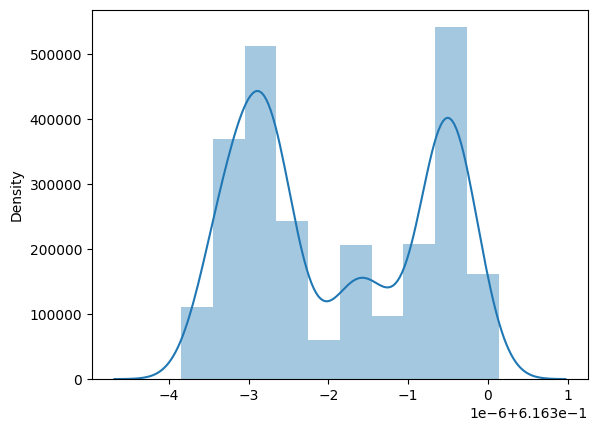

In [15]:
sns.distplot(y, hist=True)
plt.show()

### Moving average

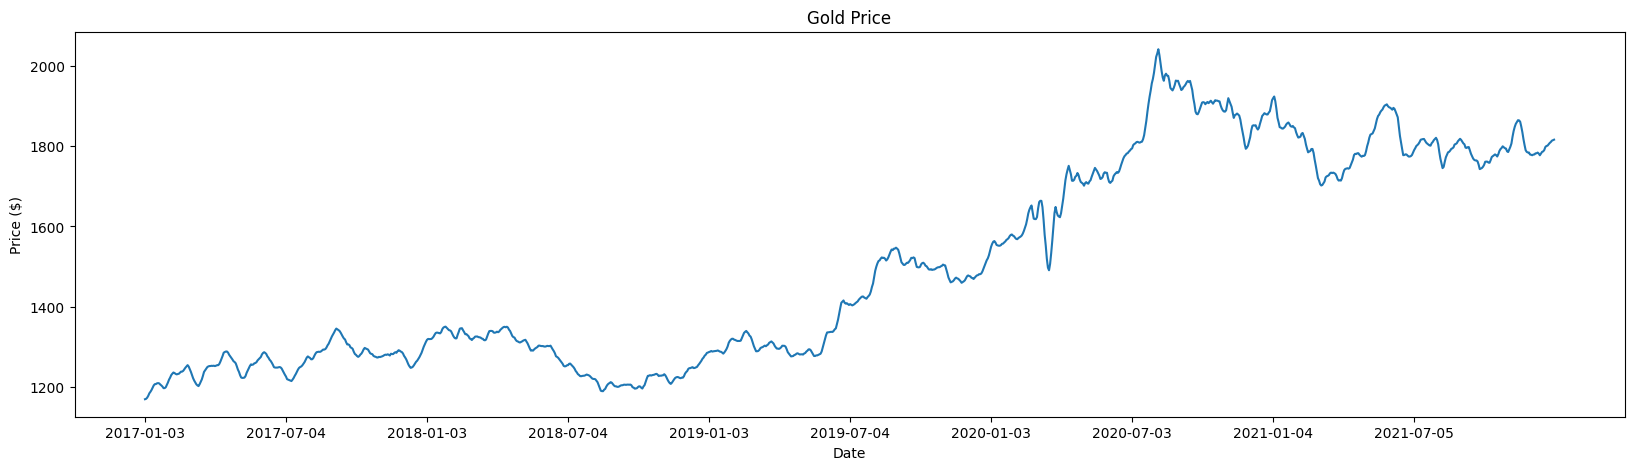

In [16]:
mas = []

for i in range(gold.shape[0]):
    if i >1:
        ma = np.array(gold['Price'][i-2:i+3]).mean()
        mas.append(ma)
    else:
        ma = np.array(gold['Price'][0:i+3]).mean()
        mas.append(ma)

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

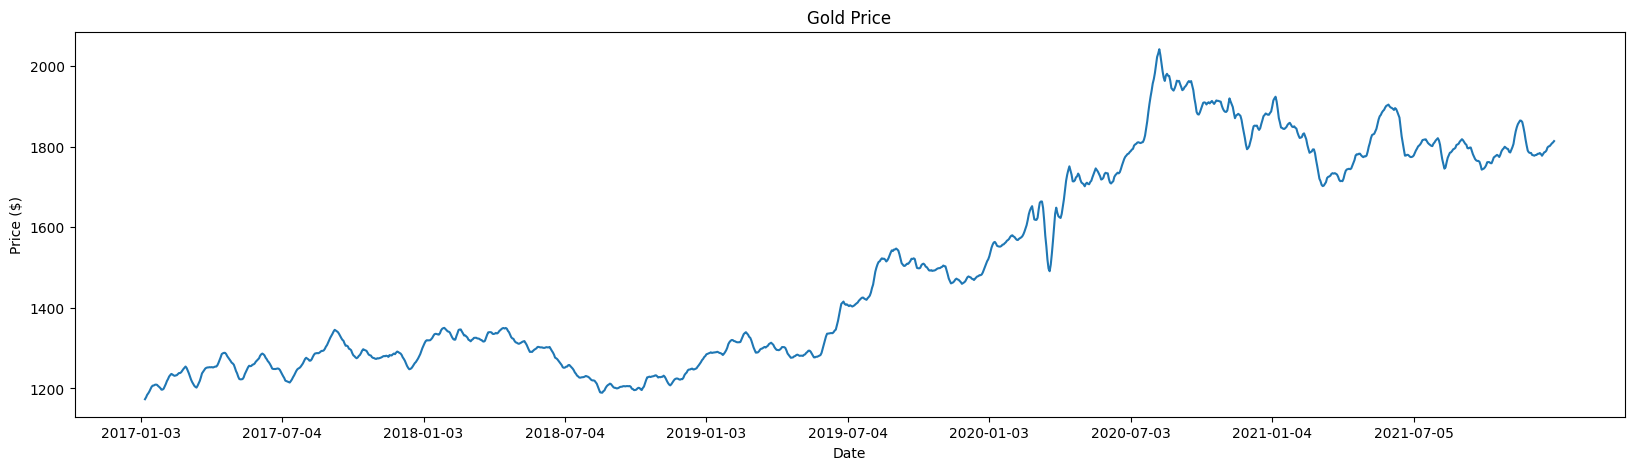

In [17]:
mas = gold['Price'].rolling(5).mean()

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

## Classical Decomposition

### Trend -> Moving average
### Seasonal -> 각 period의 data - trend 평균

<Figure size 3000x1000 with 0 Axes>

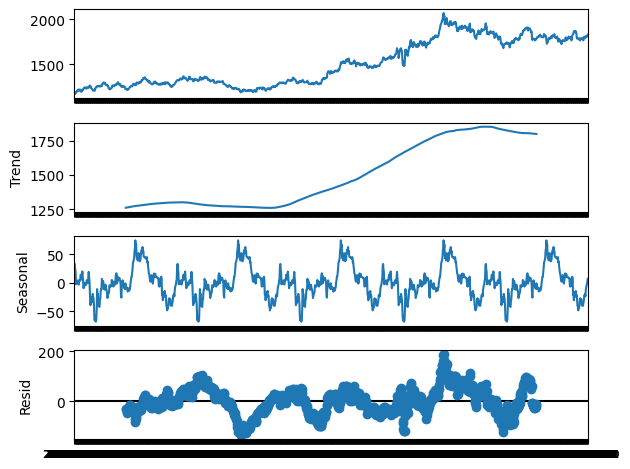

In [18]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'additive',  period = 258)
gold_decomp.plot()
plt.show()

<Figure size 3000x1000 with 0 Axes>

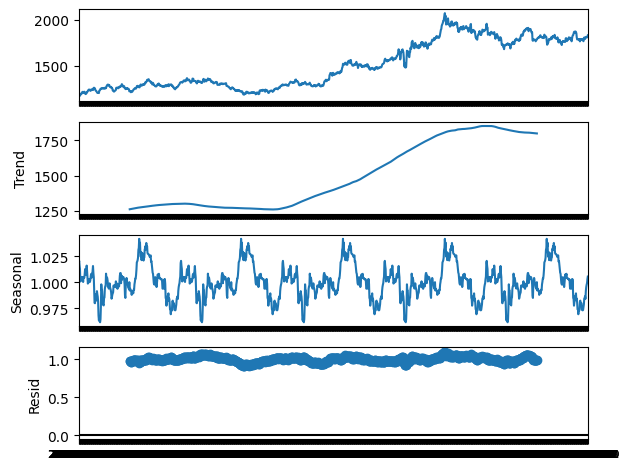

In [19]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'multiplicative',  period = 258)
gold_decomp.plot()
plt.show()

# Stationarity

## Unit root test

In [20]:
def ADF(data):

    result = adfuller(data, autolag = 'AIC')

    print('-----ADF-----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key,value))

In [21]:
print(ADF(price))
print(ADF(diff))

-----ADF-----
ADF Statistic: -0.806442
p-value: 0.8172225725
Lag: 6
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None
-----ADF-----
ADF Statistic: -17.368823
p-value: 0.0000000000
Lag: 5
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None


## ACF / PACF

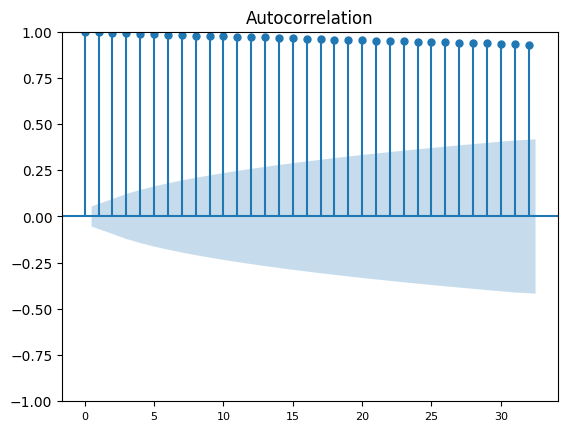

In [26]:
plot_acf(price)
plt.show()

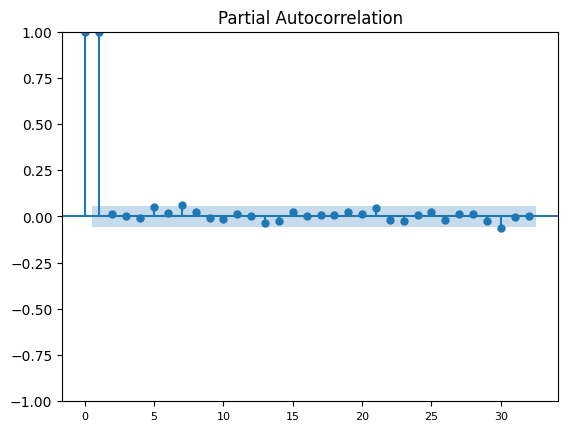

In [27]:
plot_pacf(price)
plt.show()

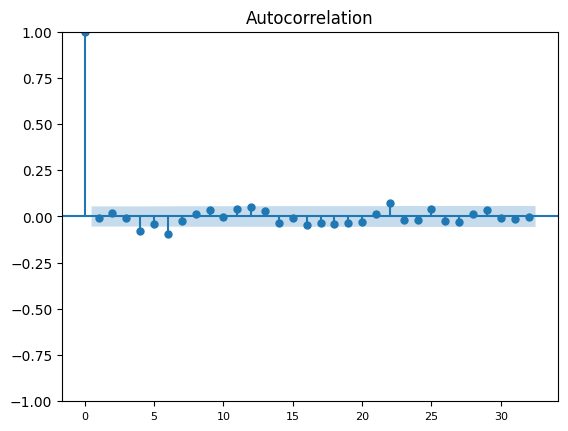

In [31]:
plot_acf(diff)
plt.show()

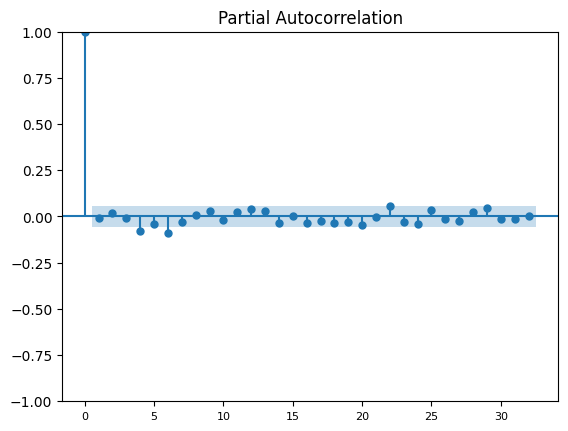

In [29]:
plot_pacf(diff)
plt.show()

# ARIMA

## Train-Test split

In [38]:
forecasting_horizon = int(gold.shape[0]*0.1)
train = price[:-forecasting_horizon]
test = price[-forecasting_horizon:]

## Fitting

In [39]:
p = range(0,3)
d = range(0,2)
q = range(0,3)

orders = list(itertools.product(p,d,q))

In [40]:
#Gold select order
dict_model = {}

for order in orders:
    model = ARIMA(train, order = order)
    model_fit = model.fit()
    dict_model[order] = [model_fit.llf, model_fit.aic, model_fit.bic]

information = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'Aic', 'Bic'])
print('By BIC')
print(information.sort_values(by=['Bic'], ascending =True))

By BIC
                   llf           Aic           Bic
(0, 1, 0) -4758.056325   9518.112650   9523.168826
(1, 1, 0) -4757.887096   9519.774192   9529.886542
(0, 1, 1) -4757.899112   9519.798225   9529.910575
(0, 1, 2) -4756.859294   9519.718588   9534.887114
(2, 1, 0) -4757.044411   9520.088823   9535.257348
(1, 1, 1) -4757.694959   9521.389919   9536.558445
(1, 1, 2) -4756.859039   9521.718077   9541.942779
(2, 1, 1) -4757.044114   9522.088229   9542.312930
(2, 1, 2) -4756.662557   9523.325113   9548.605990
(1, 0, 0) -4764.741381   9535.482762   9550.653873
(2, 0, 0) -4764.607421   9537.214842   9557.442990
(1, 0, 1) -4764.609743   9537.219485   9557.447633
(1, 0, 2) -4763.526061   9537.052122   9562.337307
(2, 0, 1) -4764.255878   9538.511757   9563.796942
(2, 0, 2) -4763.554944   9539.109888   9569.452110
(0, 0, 2) -6705.163978  13418.327957  13438.556105
(0, 0, 1) -7284.644613  14575.289225  14590.460336
(0, 0, 0) -8044.712341  16093.424682  16103.538756


In [41]:
model_aic = pm.auto_arima(train, max_p = 2, max_q=2, d =1, information_criteria = 'aic')
model_bic = pm.auto_arima(train, max_p = 2, max_q=2, d =1, information_criteria = 'bic')

print(model_aic.summary())
print(model_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1161
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4758.056
Date:                Fri, 26 Apr 2024   AIC                           9518.113
Time:                        17:02:29   BIC                           9523.169
Sample:                             0   HQIC                          9520.020
                               - 1161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       213.9357      3.771     56.728      0.000     206.544     221.327
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):              4168.74
Prob(Q):                              0.53   Pr

## Forecasting

In [42]:
#ARIMA(0,1,0)
arima_errors = []
arima_preds = []
order = (0,1,0)


for i in range(forecasting_horizon) :
    arima_model = ARIMA(price[:-forecasting_horizon+i], order = order)
    arima_model_fit = arima_model.fit()
    arima_pred = arima_model_fit.forecast(steps=1).item()
    arima_error = arima_pred - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error = abs(arima_error)
    arima_preds.append(arima_pred)
    arima_errors.append(arima_abs_error)


arima_abs_errors = np.array(arima_errors)
arima = arima_abs_errors.mean()
print(arima)

10.647286821705407


In [43]:
#Auto-ARIMA
arima_errors1 = []
arima_preds1 = []


for i in range(forecasting_horizon) :
    arima_model1 = pm.auto_arima(price[:-forecasting_horizon+i], max_p = 2, max_q=2, d =1, information_criteria = 'bic')
    arima_pred1 = arima_model1.predict(1).item()
    arima_error1 = arima_pred1 - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error1 = abs(arima_error1)
    arima_preds1.append(arima_pred1)
    arima_errors1.append(arima_abs_error1)


arima_abs_errors1 = np.array(arima_errors1)
arima1 = arima_abs_errors1.mean()
print(arima1)

10.612971913190691


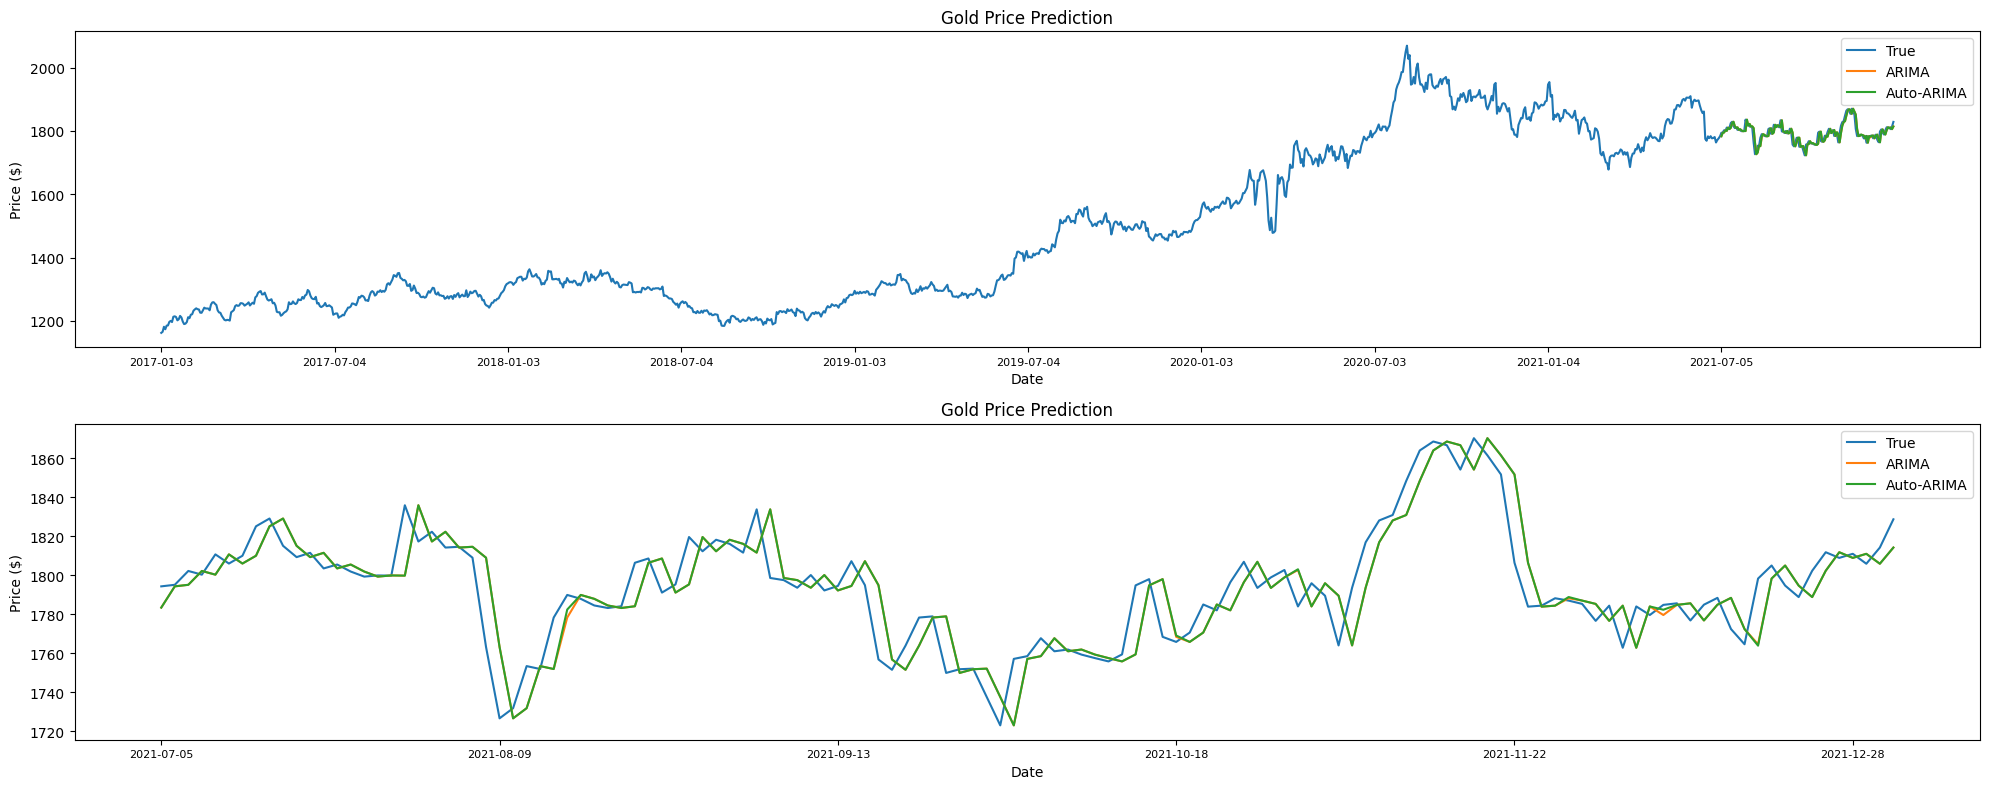

In [48]:
preds = pd.DataFrame(arima_preds, index = gold['Date'][-forecasting_horizon:])
preds1 = pd.DataFrame(arima_preds1, index = gold['Date'][-forecasting_horizon:])

fig, ax = plt.subplots(2,1,figsize = (20,8))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds, label = 'ARIMA')
ax[0].plot(x2, preds1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds, label = 'ARIMA')
ax[1].plot(x2, preds1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))

plt.tight_layout()
plt.show()

In [45]:
order = (0,1,0)
arima_model_dms = ARIMA(price[:-forecasting_horizon], order = order)
arima_model_dms_fit = arima_model_dms.fit()
arima_dms_pred = arima_model_dms_fit.forecast(steps=forecasting_horizon)
arima_dms_error = arima_dms_pred - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error = abs(arima_dms_error)
arima_dms_abs_error = np.array(arima_dms_abs_error)
print(arima_dms_abs_error.mean())

arima_model_dms1 = pm.auto_arima(price[:-forecasting_horizon], max_p = 3, max_q=3, d =1, information_criteria = 'bic')
arima_dms_pred1 = arima_model_dms1.predict(forecasting_horizon)
arima_dms_error1 = arima_dms_pred1 - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error1 = abs(arima_dms_error1)
arima_dms_abs_error1 = np.array(arima_dms_abs_error1)
arima_dms_abs_error1.mean()

23.61472868217056


23.61472868217056

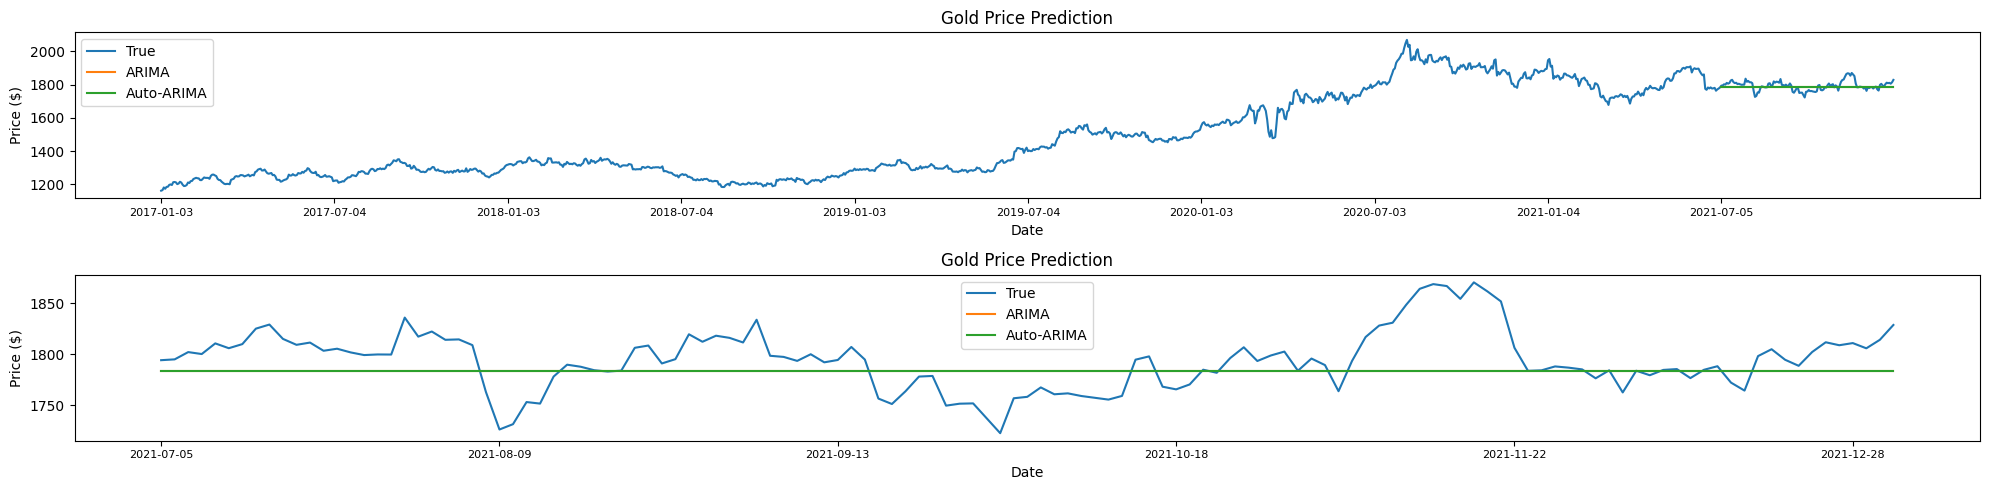

In [47]:
preds_dms= pd.DataFrame(arima_dms_pred.to_numpy(), index = gold['Date'][-forecasting_horizon:])
preds_dms1= pd.DataFrame(arima_dms_pred1.to_numpy(), index = gold['Date'][-forecasting_horizon:])


fig, ax = plt.subplots(2,1,figsize = (20,5))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds_dms, label = 'ARIMA')
ax[0].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds_dms, label = 'ARIMA')
ax[1].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))

plt.tight_layout()
plt.show()